In [1]:
import os
import glob
import gzip
import pickle

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from matplotlib.colors import LogNorm

import shapely.wkt as wkt
from shapely.geometry import Point, LineString, box
from shapely.ops import nearest_points
import lxml.etree as ET
import network_io as nio
from itertools import combinations
import random

import re

import random
import numpy as np
import matplotlib.pyplot as plt

import os
import gc
import random
import pandas as pd
import gzip
import xml.etree.ElementTree as ET

from shapely.geometry import Polygon
import alphashape



## 1. Check which combinations we have already computed

In [2]:
is_for_1pm = True
result_df_name = 'dataset_1pm_speed_reduction_10k'

paris_inside_bvd_peripherique = "../../../../data/paris_inside_bvd_per/referentiel-comptages-edit.shp"
gdf_paris_inside_bvd_per = gpd.read_file(paris_inside_bvd_peripherique)
boundary_df = alphashape.alphashape(gdf_paris_inside_bvd_per, 435).exterior[0]
linear_ring_polygon = Polygon(boundary_df)


result_path = '../../../../data/datasets_simulation_outputs/' + result_df_name + '.pt'
string_is_for_1pm = "pop_1pm" if is_for_1pm else "pop_1pct"

base_dir = '../../../../data/' + string_is_for_1pm + '_simulations/' + string_is_for_1pm + '_speed_reduction/'
subdirs_pattern = os.path.join(base_dir, 'output_networks_*')
subdirs = list(set(glob.glob(subdirs_pattern)))
subdirs.sort()

## Create subsets 

In [3]:
# List of 20 districts (represented as integers 1 to 20)
districts = list(range(1, 21))

# Function to generate 50,000 unique subsets with sizes following a normal distribution
def generate_unique_subsets(districts, mean=4, std_dev=3, target_size=50000):
    unique_subsets = set()
    
    while len(unique_subsets) < target_size:
        # Generate a random subset size from a normal distribution, round to the nearest integer
        subset_size = max(1, int(np.random.normal(mean, std_dev)))
        
        # Ensure that subset size does not exceed the number of available districts
        subset_size = min(subset_size, len(districts))
        
        # Randomly sample districts for the subset
        subset = tuple(sorted(random.sample(districts, subset_size)))
        
        # Add the subset to the set of unique subsets
        unique_subsets.add(subset)
    
    return list(unique_subsets)

# Generate 80,000 unique subsets
new_combinations = generate_unique_subsets(districts, mean=5, std_dev=1, target_size=10000)

# Check the number of unique subsets
print(f"Number of unique subsets: {len(new_combinations)}")

Number of unique subsets: 10000


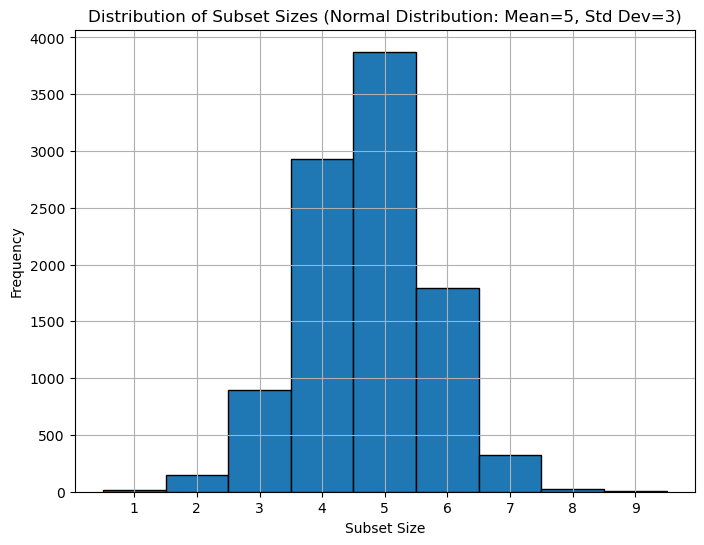

In [4]:
# Extract the sizes of the subsets
subset_sizes = [len(subset) for subset in new_combinations]

# Plot the distribution of subset sizes
plt.figure(figsize=(8, 6))
plt.hist(subset_sizes, bins=range(1, max(subset_sizes)+2), align='left', edgecolor='black')
plt.title('Distribution of Subset Sizes (Normal Distribution: Mean=5, Std Dev=3)')
plt.xlabel('Subset Size')
plt.ylabel('Frequency')
plt.xticks(range(1, max(subset_sizes)+1))
plt.grid(True)
plt.show()

# Find difference set between the new subsets and the already computed subsets

In [5]:
# Save the random_subset list to a file using pickle
with open(result_df_name + '.pkl', 'wb') as file:
    pickle.dump(new_combinations, file)

In [6]:
file_path = '../../../../data/pop_1pm_simulations/pop_1pm/paris_1pm_network.xml.gz'
districts = gpd.read_file("../../../../data/visualisation/districts_paris.geojson")

base_output_links_no_policies = '../../../../data/pop_1pm_simulations/pop_1pm/output_1pm/'
base_network_no_policies = nio.read_network_data(base_output_links_no_policies)
base_network_no_policies.rename(columns={'link': 'id'}, inplace=True)

# Parse nodes and edges
nodes_dict = nio.parse_nodes(file_path)
df_edges = nio.parse_edges(file_path, nodes_dict)
gdf_edges = gpd.GeoDataFrame(df_edges, geometry='geometry', crs='EPSG:2154')
gdf_edges_4326 = gdf_edges.to_crs(epsg=4326)

# Spatial join to find districts overlapping with each edge
gdf_edges_with_districts = gpd.sjoin(gdf_edges_4326, districts, how='left', op='intersects')

# Group by edge and aggregate the district names
gdf_edges_with_districts = gdf_edges_with_districts.groupby('id').agg({
    'from': 'first',
    'to': 'first',
    'length': 'first',
    'freespeed': 'first',
    'capacity': 'first',
    'permlanes': 'first',
    'oneway': 'first',
    'modes': 'first',
    'geometry': 'first',
    'c_ar': lambda x: list(x.dropna())
}).reset_index()

# Rename the aggregated column to 'district'
gdf_edges_with_districts.rename(columns={'c_ar': 'district'}, inplace=True)

# Convert freespeed and capacity to numeric values
gdf_edges_with_districts['freespeed'] = pd.to_numeric(gdf_edges_with_districts['freespeed'], errors='coerce')
gdf_edges_with_districts['capacity'] = pd.to_numeric(gdf_edges_with_districts['capacity'], errors='coerce')

gdf_edges_with_highway = gdf_edges_with_districts.merge(base_network_no_policies[['id', 'osm:way:highway']], on='id', how='left')
gdf_edges_with_highway.head()

higher_order_roads = ['tertiary', 'secondary', 'primary', 'secondary_link', 'primary_link', 'tertiary_link']
filtered_gdf = gdf_edges_with_highway[gdf_edges_with_highway['osm:way:highway'].isin(higher_order_roads)]
filtered_gdf = gpd.GeoDataFrame(filtered_gdf, geometry='geometry', crs='EPSG:4326')
gdf_edges_with_highway = gpd.GeoDataFrame(gdf_edges_with_highway, geometry='geometry', crs='EPSG:4326')

/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/pandas/core/reshape/merge.py:1203: RuntimeWarning: invalid value encountered in cast
  if not (lk == lk.astype(rk.dtype))[~np.isnan(lk)].all():


In [7]:
gdf_edges_with_highway['freespeed'].describe()

count    3.121600e+04
mean              inf
std               NaN
min      1.000000e+00
25%      8.333333e+00
50%      8.333333e+00
75%      8.333333e+00
max               inf
Name: freespeed, dtype: float64

In [8]:
gdf = gdf_edges_with_highway[gdf_edges_with_highway.geometry.within(linear_ring_polygon)]


/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


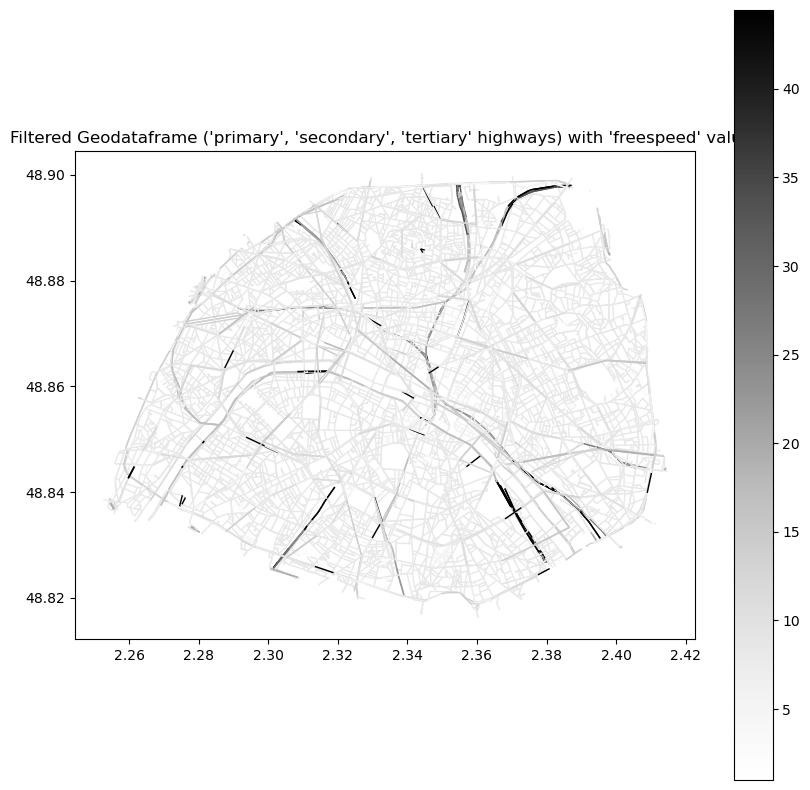

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# Step 1: Filter the GeoDataFrame based on the 
# "highway" column
# filtered_gdf = gdf[gdf['osm:way:highway'].isin(
#     ["primary", "secondary", "tertiary", "primary_link", "secondary_link", "tertiary_link"]
# )]

# Step 2: Clean 'freespeed' column again if necessary (handling inf and NaN as before)
max_finite_value = gdf['freespeed'].replace([np.inf, -np.inf], np.nan).max()
gdf['freespeed'].replace([np.inf, -np.inf], max_finite_value, inplace=True)
gdf['freespeed'].fillna(max_finite_value, inplace=True)

# Step 3: Plot the filtered GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='freespeed', cmap='Greys', linewidth=1, ax=ax, legend=True)

# Set plot title and display
plt.title("Filtered Geodataframe ('primary', 'secondary', 'tertiary' highways) with 'freespeed' values")
plt.show()

/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


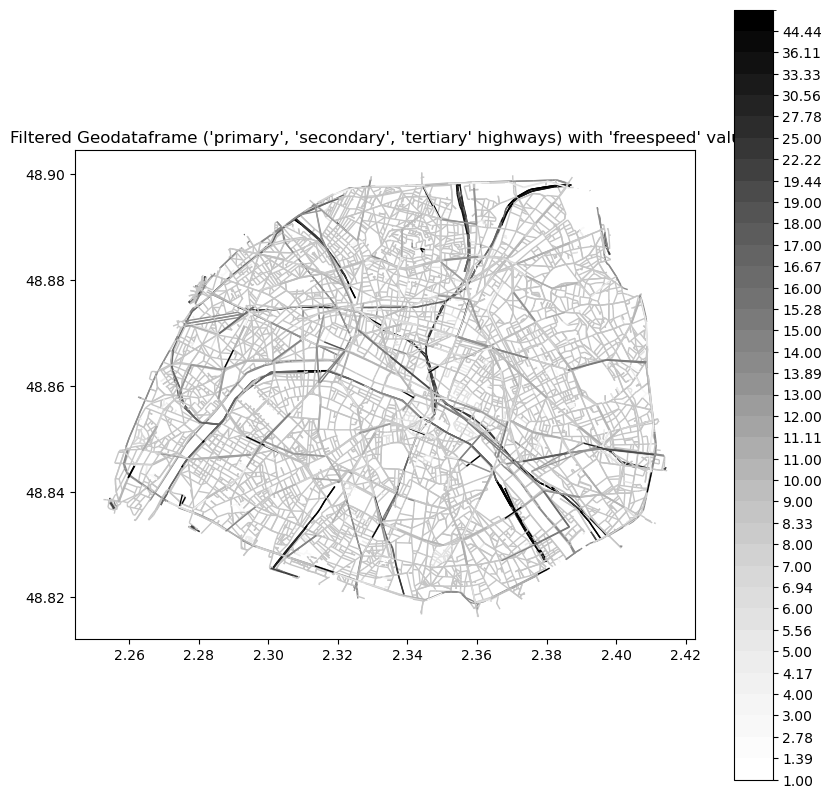

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import geopandas as gpd

# Replace inf and NaN values as you already do
max_finite_value = gdf['freespeed'].replace([np.inf, -np.inf], np.nan).max()
gdf['freespeed'].replace([np.inf, -np.inf], max_finite_value, inplace=True)
gdf['freespeed'].fillna(max_finite_value, inplace=True)

# Get the unique values in the 'freespeed' column
unique_values = np.sort(gdf['freespeed'].unique())

# Create bins based on unique values, adding a small offset for boundary correctness
bins = np.append(unique_values, unique_values[-1] + 1)

# Create a discrete colormap using BoundaryNorm
norm = BoundaryNorm(bins, ncolors=plt.get_cmap('Greys').N, clip=True)

# Plot the GeoDataFrame with discrete colorbar
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='freespeed', cmap='Greys', linewidth=1, ax=ax, legend=False, norm=norm)

# Add colorbar with discrete values
sm = plt.cm.ScalarMappable(cmap='Greys', norm=norm)
sm._A = []  # Empty array for the ScalarMappable object
cbar = fig.colorbar(sm, ax=ax, boundaries=bins, ticks=unique_values)

# Set plot title and display
plt.title("Filtered Geodataframe ('primary', 'secondary', 'tertiary' highways) with 'freespeed' values")
plt.show()


/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


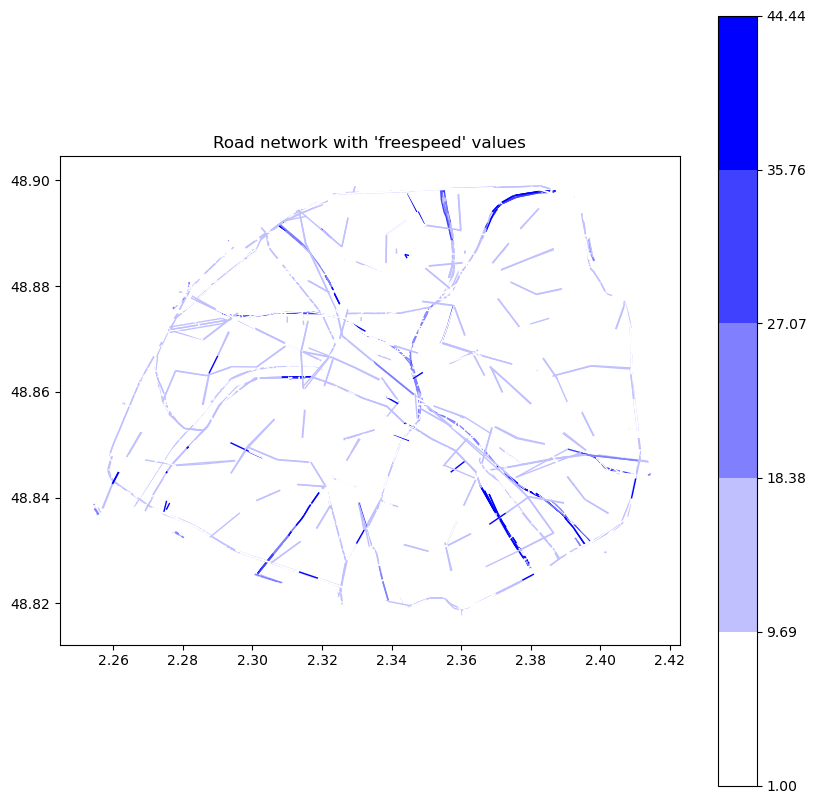

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
import geopandas as gpd

# Replace inf and NaN values as you already do
max_finite_value = gdf['freespeed'].replace([np.inf, -np.inf], np.nan).max()
gdf['freespeed'].replace([np.inf, -np.inf], max_finite_value, inplace=True)
gdf['freespeed'].fillna(max_finite_value, inplace=True)

# Define the discrete bins for the colorbar
# Adjust the number of bins and boundaries based on your data
bins = np.linspace(gdf['freespeed'].min(), gdf['freespeed'].max(), 6)  # Example: 5 bins
norm = BoundaryNorm(bins, ncolors=256, clip=True)

# Create a grey-to-blue colormap
cmap = LinearSegmentedColormap.from_list("white", ["white", "blue"])
# Plot the GeoDataFrame with discrete colorbar
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='freespeed', cmap=cmap, linewidth=1, ax=ax, legend=False, norm=norm)

# Add colorbar with discrete values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # Empty array for the ScalarMappable object
cbar = fig.colorbar(sm, ax=ax, boundaries=bins, ticks=bins)

# Set plot title and display
plt.title("Road network with 'freespeed' values")
plt.show()


In [12]:
gdf['freespeed'].describe()

count    23699.000000
mean         9.361607
std          5.027742
min          1.000000
25%          8.333333
50%          8.333333
75%          8.333333
max         44.444444
Name: freespeed, dtype: float64

/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/Users/elenanatterer/anaconda3/envs/Paris_Analysis/lib/python3.10/site-packages/pandas/core/generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


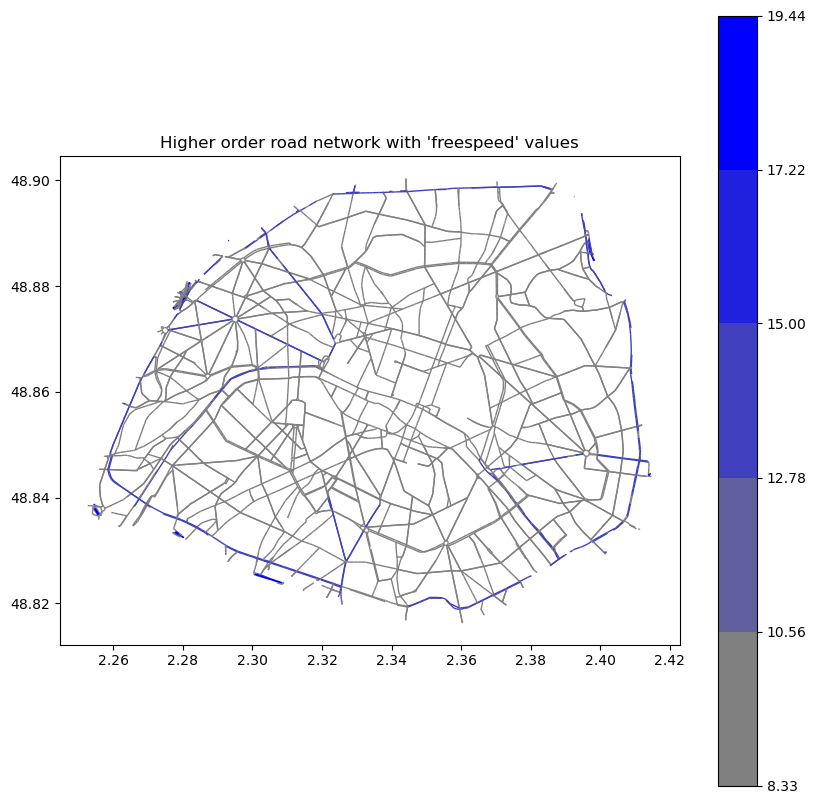

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, LinearSegmentedColormap
import geopandas as gpd

gdf = gdf[gdf['osm:way:highway'].isin(
    ["trunk", "primary", "secondary", "tertiary","trunk_link", "primary_link", "secondary_link", "tertiary_link"]
)]

max_finite_value = gdf['freespeed'].replace([np.inf, -np.inf], np.nan).max()
gdf['freespeed'].replace([np.inf, -np.inf], max_finite_value, inplace=True)
gdf['freespeed'].fillna(max_finite_value, inplace=True)

# Define the discrete bins for the colorbar
# Adjust the number of bins and boundaries based on your data
bins = np.linspace(gdf['freespeed'].min(), gdf['freespeed'].max(), 6)  # Example: 5 bins
norm = BoundaryNorm(bins, ncolors=256, clip=True)

# Create a grey-to-blue colormap
cmap = LinearSegmentedColormap.from_list("grey_blue", ["grey", "blue"])
# Plot the GeoDataFrame with discrete colorbar
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(column='freespeed', cmap=cmap, linewidth=1, ax=ax, legend=False, norm=norm)

# Add colorbar with discrete values
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []  # Empty array for the ScalarMappable object
cbar = fig.colorbar(sm, ax=ax, boundaries=bins, ticks=bins)

# Set plot title and display
plt.title("Higher order road network with 'freespeed' values")
plt.show()


In [14]:
gdf['freespeed'].describe()

count    9798.000000
mean        8.996167
std         1.867919
min         8.333333
25%         8.333333
50%         8.333333
75%         8.333333
max        19.444444
Name: freespeed, dtype: float64

In [15]:
# # Directory to save the files
# output_base_dir = '../../../../data/pop_1pm_simulations/pop_1pm_policies_combinations_with_normal_dist/networks/'

# # Number of files per directory
# files_per_dir = 1000

# # Function to write XML to a compressed .gz file
# def write_xml_to_gz(xml_tree, file_path):
#     with gzip.open(file_path, 'wb') as f:
#         xml_tree.write(f, encoding='utf-8', xml_declaration=True)

# # Ensure the base output directory exists
# os.makedirs(output_base_dir, exist_ok=True)

# # Create and save the networks
# for i, combination in enumerate(new_combinations):
#     if isinstance(combination, int):
#         combination = (combination,)
#     df_copy = gdf_edges_with_highway.copy()
#     df_copy['policy_introduced'] = df_copy['district'].apply(
#         lambda districts: any(d in districts for d in combination)
#     ) & df_copy.apply(
#         lambda row: 'car' in row['modes'] and row['osm:way:highway'] in higher_order_roads, axis=1
#     )
#     # Modify freespeed and capacity based on the policy_introduced condition
#     df_copy.loc[df_copy['policy_introduced'], 'freespeed'] = df_copy.loc[df_copy['policy_introduced'], 'capacity'] / 2

#     # Determine the subdirectory based on the file index
#     dir_index = (i // files_per_dir) + 1
#     subdir_name = f"networks_{dir_index * files_per_dir}"
#     output_dir = os.path.join(output_base_dir, subdir_name)
    
#     # Create the subdirectory if it doesn't exist
#     os.makedirs(output_dir, exist_ok=True)
    
#     # Determine the filename based on the combination
#     if len(combination) == 1:
#         filename = f"network_d_{combination[0]}.xml.gz"
#     else:
#         filename = f"network_d_{'_'.join(map(str, combination))}.xml.gz"
    
#     # Convert the DataFrame to XML
#     xml_tree = nio.dataframe_to_xml(df_copy, nodes_dict)
    
#     # Write the XML to a compressed .gz file
#     file_path = os.path.join(output_dir, filename)
#     nio.write_xml_to_gz(xml_tree, file_path)

#     # Clear the dataframe from memory
#     del df_copy
#     gc.collect()

# # Example: Display the file paths of the saved files
# output_files = [os.path.join(root, f) for root, _, files in os.walk(output_base_dir) for f in files]
# print(output_files)